# Quickstart

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [3]:
import numpy as np
import pylab as plt
import swyft

## Setup the forward model

In [4]:
device = "cpu"
n_training_samples = 10_000
n_parameters = 2
marginal_indices_1d, marginal_indices_2d = swyft.utils.get_corner_marginal_indices(n_parameters)
observation_key = "x"

n_weighted_samples = 10_000

In [5]:
def model(v, sigma = 0.2):
    x = v + np.random.randn(n_parameters) * sigma
    return {observation_key: x}

v_o = np.zeros(n_parameters)
observation_o = model(v_o, sigma = 0.)

n_observation_features = observation_o[observation_key].shape[0]
observation_shapes = {key: value.shape for key, value in observation_o.items()}

In [6]:
simulator = swyft.Simulator(
    model, 
    n_parameters, 
    sim_shapes=observation_shapes
)

## Setup the prior and storage

In [7]:
low = -1 * np.ones(n_parameters)
high = 1 * np.ones(n_parameters)
prior = swyft.get_uniform_prior(low, high)

store = swyft.Store.memory_store(simulator)
store.add(n_training_samples, prior)
store.simulate()

Creating new store.
Store: Adding 10127 new samples to simulator store.


In [8]:
dataset = swyft.Dataset(n_training_samples, prior, store)

## Train a 1d marginal estimator

In [9]:
network_1d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_1d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_1d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_1d,
    network=network_1d,
    device=device,
)

In [10]:
mre_1d.train(dataset)

training: lr=5e-05, epoch=25, validation loss=1.5432


## Create a simple violin plot to view the 1d marginals

In [11]:
n_rejection_samples = 5_000

posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
samples_1d = posterior_1d.sample(n_rejection_samples, observation_o)

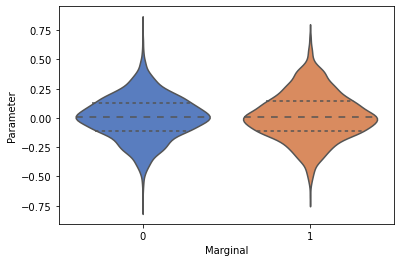

In [12]:
_ = swyft.violin(samples_1d)

## Train a 2d marginal estimator

In [13]:
network_2d = swyft.get_marginal_classifier(
    observation_key=observation_key,
    marginal_indices=marginal_indices_2d,
    observation_shapes=observation_shapes,
    n_parameters=n_parameters,
    hidden_features=32,
    num_blocks=2,
)

mre_2d = swyft.MarginalRatioEstimator(
    marginal_indices=marginal_indices_2d,
    network=network_2d,
    device=device,
)

In [14]:
mre_2d.train(dataset)

training: lr=5e-06, epoch=25, validation loss=0.47269


## Combine the two to create a corner plot

In [15]:
posterior_1d = swyft.MarginalPosterior(mre_1d, prior)
weighted_samples_1d = posterior_1d.weighted_sample(n_weighted_samples, observation_o)

posterior_2d = swyft.MarginalPosterior(mre_2d, prior)
weighted_samples_2d = posterior_2d.weighted_sample(n_weighted_samples, observation_o)

1it [00:04,  4.32s/it]


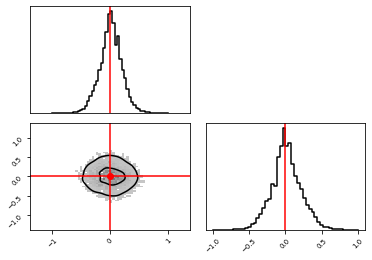

In [16]:
_, _ = swyft.plot.corner(
    weighted_samples_1d.get_df_dict(), 
    weighted_samples_2d.get_df_dict(),
    kde=True,
    truth=v_o,
)

## Test the expected coverage probability

In [17]:
n_observations = 200
n_posterior_samples = 5_000

empirical_mass_1d, _ = posterior_1d.empirical_mass(n_observations, n_posterior_samples, dataset)
empirical_mass_2d, _ = posterior_2d.empirical_mass(n_observations, n_posterior_samples, dataset)

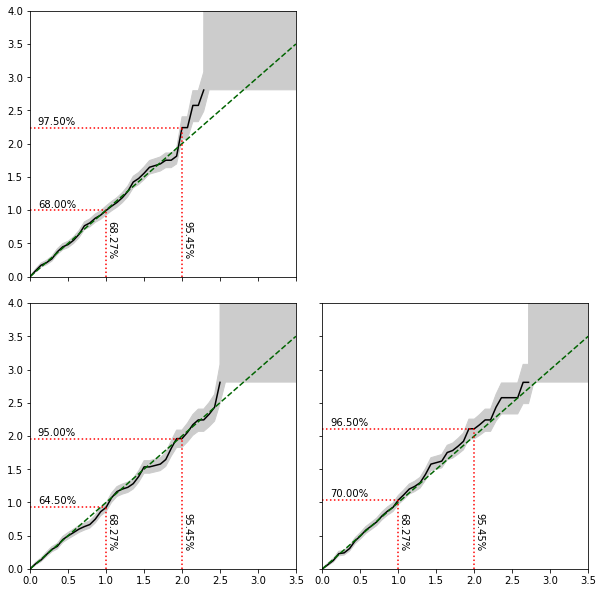

In [18]:
_, _ = swyft.empirical_z_score_corner(empirical_mass_1d, empirical_mass_2d, figsize=(10,10))